In [1]:
import torch 
print("CUDA AVAILABLE", torch.cuda.is_available())

CUDA AVAILABLE True


In [3]:
if torch.cuda.is_available():
    print("GPU Device name: ", torch.cuda.get_device_name(0))
    print("Number of GPU: ", torch.cuda.device_count())
else:
    print("no cuda is detected")

GPU Device name:  NVIDIA GeForce RTX 4060 Laptop GPU
Number of GPU:  1


In [5]:
!pip install xlrd

In [19]:
import os

folder_path = r"E:\SurfacePredictor\data1"

xls_files = [file for file in os.listdir(folder_path) if file.endswith(".xls")]

print("Files found: ")
for file in xls_files:
    print("->",file)

Files found: 
-> polished surface 2.xls
-> polished surface.xls
-> rough cement wall.xls
-> rough edge.xls
-> rough surface 2.xls
-> rough surface.xls
-> smooth cement wall.xls
-> smooth surface 2.xls
-> smooth surface.xls
-> sticky surface 2.xls
-> sticky surface.xls


In [20]:
import pandas as pd
import os
from glob import glob

# Path to folder containing all the .xls files
folder_path = r"E:\SurfacePredictor\data1"
file_paths = glob(os.path.join(folder_path, "*.xls"))

# Surface label mapping based on filename
def infer_surface_from_filename(filename):
    name = os.path.basename(filename).lower()
    if "polished" in name:
        return "POLISHED"
    elif "rough" in name:
        return "ROUGH"
    elif "smooth" in name:
        return "SMOOTH"
    elif "sticky" in name:
        return "STICKY"
    else:
        return "UNKNOWN"

# Storage for cleaned data
cleaned_dfs = []

# Processing each file
for file_path in file_paths:
    try:
        # Read Excel file
        df = pd.read_excel(file_path)

        # Fix column names if needed
        df.columns = [col.strip() for col in df.columns]
        if "Time" not in df.columns or "Resistance" not in df.columns:
            df.columns = ['Time', 'Resistance'] + df.columns[2:].tolist()

        # Drop empty columns if present
        df = df[['Time', 'Resistance']]

        # Reset time to start from 1
        df['Time'] = range(1, len(df) + 1)

        # Compute difference and rolling features
        df['Resistance_diff'] = df['Resistance'].diff().fillna(0)
        df['Rolling_mean_5'] = df['Resistance'].rolling(5).mean().bfill()
        df['Rolling_std_5'] = df['Resistance'].rolling(5).std().bfill()

        # Add labels
        df['Surface'] = infer_surface_from_filename(file_path)
        df['FileName'] = os.path.basename(file_path)

        # Append to master list
        cleaned_dfs.append(df)

    except Exception as e:
        print(f"❌ Failed to process {file_path}: {e}")

# Merge all cleaned DataFrames
merged_df = pd.concat(cleaned_dfs, ignore_index=True)

# Save to CSV
output_path = os.path.join(folder_path, "Cleaned_Surface_Data_All.csv")
merged_df.to_csv(output_path, index=False)
print(f"✅ All files cleaned and saved to: {output_path}")


✅ All files cleaned and saved to: E:\SurfacePredictor\data1\Cleaned_Surface_Data_All.csv


In [21]:
import pandas as pd

# Load the cleaned CSV
df = pd.read_csv(r"E:\SurfacePredictor\data1\Cleaned_Surface_Data_All.csv")

# Show surface-wise row counts
print("🧮 Surface-wise distribution:\n")
print(df['Surface'].value_counts())

# Show sample rows
print("\n🔍 Preview of data:")
print(df.head())


🧮 Surface-wise distribution:

Surface
ROUGH       785
SMOOTH      520
POLISHED    396
STICKY      355
Name: count, dtype: int64

🔍 Preview of data:
   Time  Resistance  Resistance_diff  Rolling_mean_5  Rolling_std_5   Surface  \
0     1      784.50             0.00          787.63      27.131602  POLISHED   
1     2      831.56            47.06          787.63      27.131602  POLISHED   
2     3      782.69           -48.87          787.63      27.131602  POLISHED   
3     4      782.69             0.00          787.63      27.131602  POLISHED   
4     5      756.71           -25.98          787.63      27.131602  POLISHED   

                 FileName  
0  polished surface 2.xls  
1  polished surface 2.xls  
2  polished surface 2.xls  
3  polished surface 2.xls  
4  polished surface 2.xls  


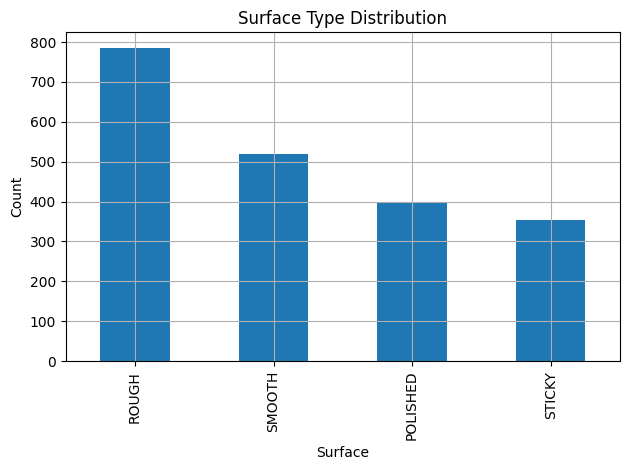

In [22]:
import matplotlib.pyplot as plt

df['Surface'].value_counts().plot(kind='bar', title='Surface Type Distribution', xlabel='Surface', ylabel='Count')
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
import pandas as pd

# Load cleaned dataset
df = pd.read_csv(r"E:\SurfacePredictor\data1\Cleaned_Surface_Data_All.csv")

# Check for nulls
print("🔍 Null values per column:\n", df.isnull().sum())

# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"\n🧼 Total duplicate rows: {duplicates}")

# Show data types
print("\n📂 Data types:\n", df.dtypes)


🔍 Null values per column:
 Time               0
Resistance         0
Resistance_diff    0
Rolling_mean_5     0
Rolling_std_5      0
Surface            0
FileName           0
dtype: int64

🧼 Total duplicate rows: 0

📂 Data types:
 Time                 int64
Resistance         float64
Resistance_diff    float64
Rolling_mean_5     float64
Rolling_std_5      float64
Surface             object
FileName            object
dtype: object


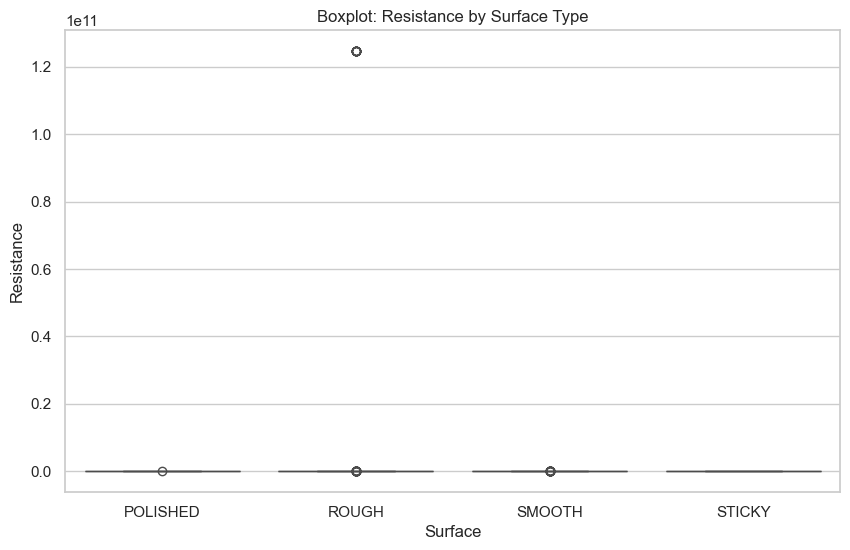

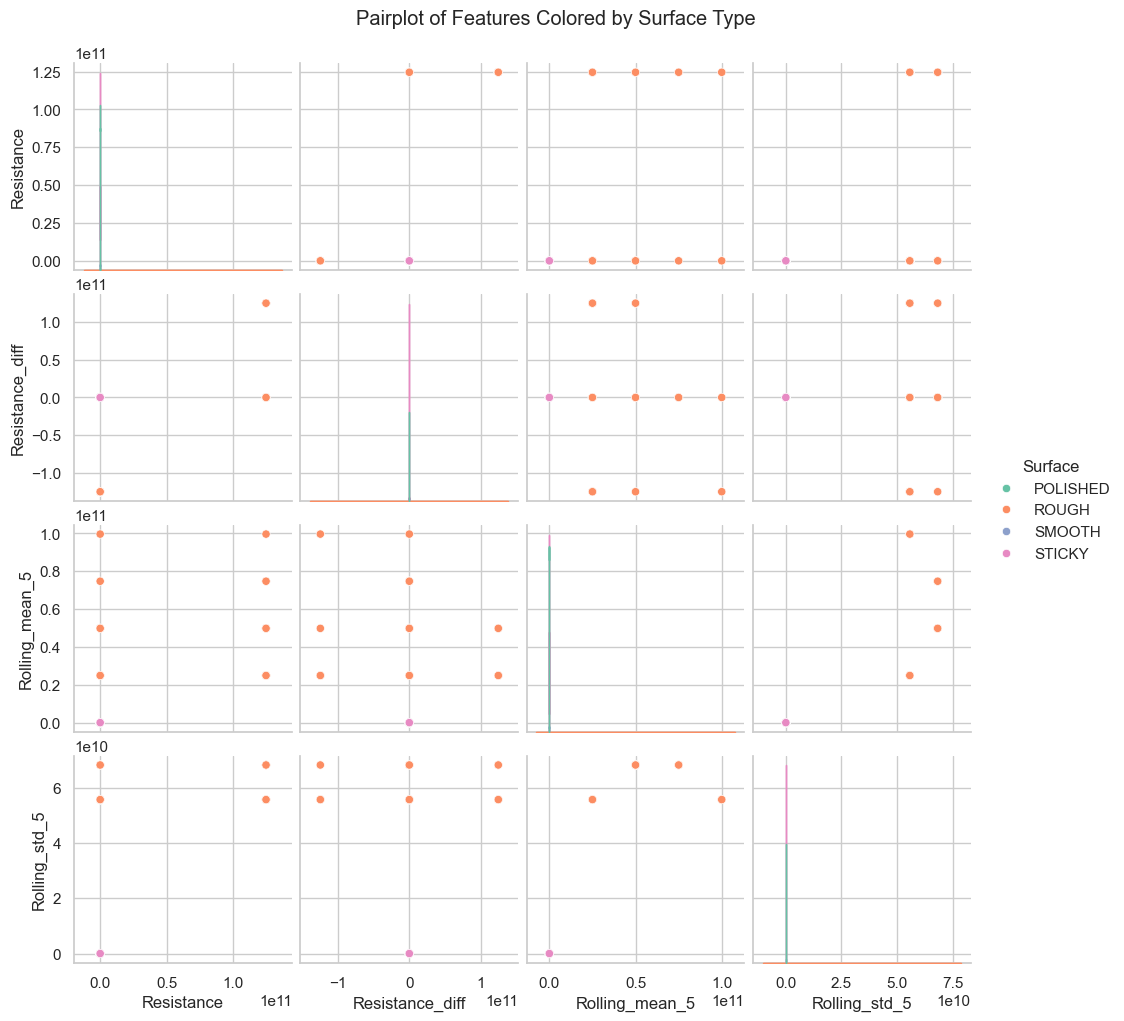

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# 1️⃣ Boxplot of Resistance by Surface
plt.figure(figsize=(10, 6))
sns.boxplot(x='Surface', y='Resistance', data=df)
plt.title('Boxplot: Resistance by Surface Type')
plt.show()

# 2️⃣ Pairplot to visualize feature relationships (optional)
selected_features = ['Resistance', 'Resistance_diff', 'Rolling_mean_5', 'Rolling_std_5']
sns.pairplot(df[selected_features + ['Surface']], hue='Surface', palette='Set2')
plt.suptitle("Pairplot of Features Colored by Surface Type", y=1.02)
plt.show()


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Load cleaned data
df = pd.read_csv(r"E:\SurfacePredictor\data1\Cleaned_Surface_Data_All.csv")

# Encode surface labels
le = LabelEncoder()
df['Encoded_Surface'] = le.fit_transform(df['Surface'])

# Define features and target
X = df[['Resistance', 'Resistance_diff', 'Rolling_mean_5', 'Rolling_std_5']]
y = df['Encoded_Surface']

# Train-test split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Show class distribution after SMOTE
print("✅ Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())


✅ Class distribution after SMOTE:
Encoded_Surface
0    549
3    549
1    549
2    549
Name: count, dtype: int64


In [27]:
final_model = XGBClassifier(
    n_estimators=901,
    max_depth=7,
    learning_rate=0.2538,
    subsample=0.7012,
    colsample_bytree=0.6154,
    gamma=0.4453,
    reg_alpha=0.9734,
    reg_lambda=0.9005,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
final_model.fit(X_train_smote, y_train_smote)


E:\SurfacePredictor\surface\lib\site-packages\xgboost\training.py:183: UserWarning: [15:45:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6154, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=0.4453,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2538, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=901, n_jobs=None,
              num_parallel_tree=None, ...)

In [28]:
y_pred_final = final_model.predict(X_test)
print(classification_report(y_test, y_pred_final, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred_final))


              precision    recall  f1-score   support

    POLISHED       0.67      0.74      0.70       119
       ROUGH       0.96      0.97      0.96       236
      SMOOTH       0.87      0.84      0.85       156
      STICKY       0.72      0.67      0.70       106

    accuracy                           0.84       617
   macro avg       0.81      0.80      0.80       617
weighted avg       0.84      0.84      0.84       617

[[ 88   0   7  24]
 [  0 228   8   0]
 [ 13   9 131   3]
 [ 30   0   5  71]]


In [30]:
import pandas as pd

# Load the cleaned surface dataset
file_path = r"E:\SurfacePredictor\data1\Cleaned_Surface_Data_All.csv"
df = pd.read_csv(file_path)

# Filter rows corresponding to the 'STICKY' surface type
sticky_df = df[df['Surface'] == 'STICKY']

# Display the first 10 rows of the sticky surface data
print("🔍 Preview of Sticky Surface Data:")
print(sticky_df.head(10))


🔍 Preview of Sticky Surface Data:
      Time  Resistance  Resistance_diff  Rolling_mean_5  Rolling_std_5  \
1701     1      782.69             0.00         772.628      10.383009   
1702     2      783.60             0.91         772.628      10.383009   
1703     3      770.08           -13.52         772.628      10.383009   
1704     4      767.40            -2.68         772.628      10.383009   
1705     5      759.37            -8.03         772.628      10.383009   
1706     6      759.37             0.00         767.964       9.962351   
1707     7      754.05            -5.32         762.054       6.547292   
1708     8      751.40            -2.65         758.318       6.139436   
1709     9      744.36            -7.04         753.710       6.263893   
1710    10      745.23             0.87         750.882       6.261635   

     Surface              FileName  
1701  STICKY  sticky surface 2.xls  
1702  STICKY  sticky surface 2.xls  
1703  STICKY  sticky surface 2.xls  
170

In [34]:
import os
import pandas as pd
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv(r"E:\SurfacePredictor\data1\Cleaned_Surface_Data_All.csv")

# Encode surface labels
le = LabelEncoder()
df['Encoded_Surface'] = le.fit_transform(df['Surface'])

# Features and target
X = df[['Time', 'Resistance', 'Resistance_diff', 'Rolling_mean_5', 'Rolling_std_5']]
y = df['Encoded_Surface']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

best_model = xgb.XGBClassifier(
    n_estimators=901,
    max_depth=7,
    learning_rate=0.2537947481700687,
    subsample=0.7012207607012307,
    colsample_bytree=0.615366186335907,
    gamma=0.4453223756583255,
    reg_alpha=0.9733636801904174,
    reg_lambda=0.9005050684770448,
    eval_metric='mlogloss',
    random_state=42
)

best_model.fit(X_resampled, y_resampled)


model_dir = r"E:\SurfacePredictor\models"
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, "best_xgboost_model.pkl")
joblib.dump(best_model, model_path)

print(f"✅ Model saved successfully at: {model_path}")


✅ Model saved successfully at: E:\SurfacePredictor\models\best_xgboost_model.pkl


In [35]:
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder

# Load the saved model
model_path = r"E:\SurfacePredictor\models\best_xgboost_model.pkl"
model = joblib.load(model_path)

# Load full dataset for reference
df = pd.read_csv(r"E:\SurfacePredictor\data1\Cleaned_Surface_Data_All.csv")

# Encode labels again (same as training)
le = LabelEncoder()
df['Encoded_Surface'] = le.fit_transform(df['Surface'])

# Filter sticky surface
sticky_df = df[df['Surface'] == 'STICKY']

# Choose a random sample or a specific row for test
sample = sticky_df.sample(1, random_state=42)  # You can also use sticky_df.iloc[0] for fixed one

# Extract feature columns
X_sample = sample[['Time', 'Resistance', 'Resistance_diff', 'Rolling_mean_5', 'Rolling_std_5']]

# Predict
pred_encoded = model.predict(X_sample)[0]
pred_label = le.inverse_transform([pred_encoded])[0]

# Show result
print("🔍 Input Sample:")
print(X_sample)
print(f"\n🎯 Predicted Surface Type: {pred_label}")
print(f"✅ Actual Surface Type: {sample['Surface'].values[0]}")


🔍 Input Sample:
      Time  Resistance  Resistance_diff  Rolling_mean_5  Rolling_std_5
1928    55      696.95              0.0          696.95            0.0

🎯 Predicted Surface Type: STICKY
✅ Actual Surface Type: STICKY


In [36]:
import pandas as pd
import joblib

# Load the model
model = joblib.load(r"E:\SurfacePredictor\models\best_xgboost_model.pkl")

# Custom input sample from STICKY surface
sample = pd.DataFrame([{
    'Time': 8,
    'Resistance': 751.40,
    'Resistance_diff': -2.65,
    'Rolling_mean_5': 758.318,
    'Rolling_std_5': 6.139436
}])

# Predict
prediction = model.predict(sample)[0]

# Label decoding
label_mapping = {
    0: 'POLISHED',
    1: 'ROUGH',
    2: 'SMOOTH',
    3: 'STICKY'
}
print(f"🧠 Predicted Surface Type: {label_mapping[prediction]}")


🧠 Predicted Surface Type: POLISHED


In [37]:
import pandas as pd
import joblib

# Load the model
model = joblib.load(r"E:\SurfacePredictor\models\best_xgboost_model.pkl")

# Example input sample from ROUGH surface
sample = pd.DataFrame([{
    'Time': 12,
    'Resistance': 890.23,
    'Resistance_diff': -1.77,
    'Rolling_mean_5': 895.56,
    'Rolling_std_5': 7.1198
}])

# Predict
prediction = model.predict(sample)[0]

# Label decoding
label_mapping = {
    0: 'POLISHED',
    1: 'ROUGH',
    2: 'SMOOTH',
    3: 'STICKY'
}
print(f"🧠 Predicted Surface Type: {label_mapping[prediction]}")


🧠 Predicted Surface Type: POLISHED


In [38]:
import pandas as pd

# Load the full cleaned dataset
file_path = r"E:\SurfacePredictor\data1\Cleaned_Surface_Data_All.csv"
df = pd.read_csv(file_path)

# Filter for SMOOTH surface
smooth_df = df[df['Surface'] == 'SMOOTH']

# Display first 10 rows of SMOOTH surface data
print(smooth_df.head(10))


      Time  Resistance  Resistance_diff  Rolling_mean_5  Rolling_std_5  \
1181     1     2523.17             0.00        2538.604     331.293128   
1182     2     2350.34          -172.83        2538.604     331.293128   
1183     3     2500.47           150.13        2538.604     331.293128   
1184     4     2227.87          -272.60        2538.604     331.293128   
1185     5     3091.17           863.30        2538.604     331.293128   
1186     6     2385.69          -705.48        2511.108     338.520635   
1187     7     2373.84           -11.85        2515.808     335.883382   
1188     8     2569.29           195.45        2529.572     336.507212   
1189     9     2694.51           125.22        2622.900     293.929534   
1190    10     2613.77           -80.74        2527.420     142.129076   

     Surface                FileName  
1181  SMOOTH  smooth cement wall.xls  
1182  SMOOTH  smooth cement wall.xls  
1183  SMOOTH  smooth cement wall.xls  
1184  SMOOTH  smooth cement w

In [39]:
import pandas as pd
import joblib

# Load the trained XGBoost model
model = joblib.load(r"E:\SurfacePredictor\models\best_xgboost_model.pkl")

# Define the input sample (from SMOOTH surface)
sample = pd.DataFrame([{
    'Time': 8,
    'Resistance': 2569.29,
    'Resistance_diff': 195.45,
    'Rolling_mean_5': 2529.572,
    'Rolling_std_5': 336.507212
}])

# Predict
prediction = model.predict(sample)[0]

# Decode the prediction
label_mapping = {
    0: 'POLISHED',
    1: 'ROUGH',
    2: 'SMOOTH',
    3: 'STICKY'
}

print(f"🧠 Predicted Surface Type: {label_mapping[prediction]}")


🧠 Predicted Surface Type: SMOOTH


C:\Users\Nikhil S\AppData\Local\Temp\ipykernel_15496\2453287997.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smooth_df['PCA1'] = pca_result[:, 0]
C:\Users\Nikhil S\AppData\Local\Temp\ipykernel_15496\2453287997.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smooth_df['PCA2'] = pca_result[:, 1]
C:\Users\Nikhil S\AppData\Local\Temp\ipykernel_15496\2453287997.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

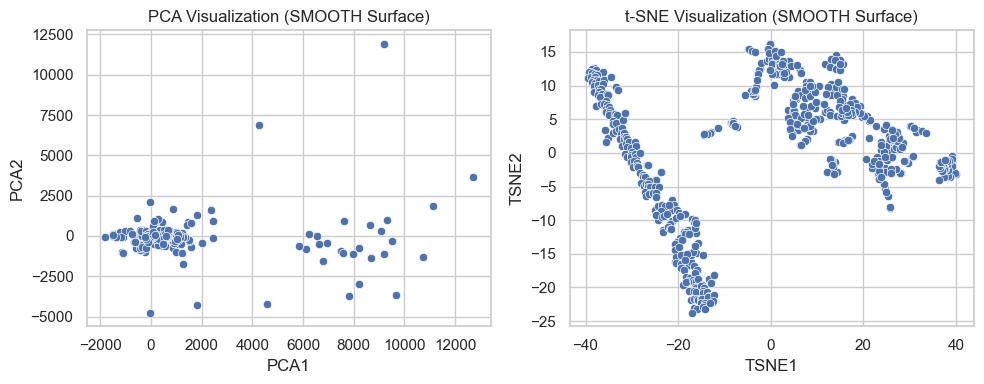

In [40]:
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
file_path = r"E:\SurfacePredictor\data1\Cleaned_Surface_Data_All.csv"
df = pd.read_csv(file_path)

# Encode surface labels
label_map = {'POLISHED': 0, 'ROUGH': 1, 'SMOOTH': 2, 'STICKY': 3}
df['Surface_Encoded'] = df['Surface'].map(label_map)

# Select only SMOOTH samples
smooth_df = df[df['Surface'] == 'SMOOTH']

# Select features for PCA and t-SNE
features = ['Time', 'Resistance', 'Resistance_diff', 'Rolling_mean_5', 'Rolling_std_5']
X = smooth_df[features]

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
smooth_df['PCA1'] = pca_result[:, 0]
smooth_df['PCA2'] = pca_result[:, 1]

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(X)
smooth_df['TSNE1'] = tsne_result[:, 0]
smooth_df['TSNE2'] = tsne_result[:, 1]

# Plot PCA
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(data=smooth_df, x='PCA1', y='PCA2')
plt.title('PCA Visualization (SMOOTH Surface)')

# Plot t-SNE
plt.subplot(1, 2, 2)
sns.scatterplot(data=smooth_df, x='TSNE1', y='TSNE2')
plt.title('t-SNE Visualization (SMOOTH Surface)')

plt.tight_layout()
plt.show()


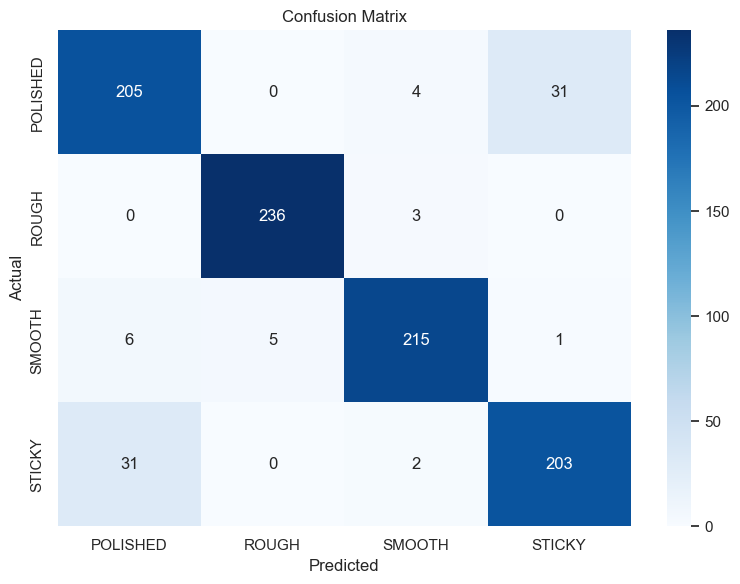

,Time,Resistance,Resistance_diff,Rolling_mean_5,Rolling_std_5,Surface,Predicted_Surface
1148,110,1529.27,-134.55,2349.984,0.000000,ROUGH,ROUGH
435,40,6142.89,-404.79,6429.406,169.196655,ROUGH,ROUGH
607,212,5706.11,-514.56,5704.762,302.166796,ROUGH,ROUGH


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import confusion_matrix, classification_report

# Load cleaned dataset and trained model
df = pd.read_csv(r"E:\SurfacePredictor\data1\Cleaned_Surface_Data_All.csv")
model = joblib.load(r"E:\SurfacePredictor\models\best_xgboost_model.pkl")

# Filter ROUGH surface samples
rough_df = df[df['Surface'] == 'ROUGH']

# Manually test 3 samples from ROUGH surface
manual_samples = rough_df.sample(3, random_state=42)
features = ['Time', 'Resistance', 'Resistance_diff', 'Rolling_mean_5', 'Rolling_std_5']
X_manual = manual_samples[features]
y_actual = manual_samples['Surface'].values

# Predict
y_pred = model.predict(X_manual)

# Decode predictions
label_mapping = {
    0: 'POLISHED',
    1: 'ROUGH',
    2: 'SMOOTH',
    3: 'STICKY'
}
decoded_pred = [label_mapping[p] for p in y_pred]

# Confusion Matrix on full test set
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()
df['Encoded_Surface'] = le.fit_transform(df['Surface'])
X = df[features]
y = df['Encoded_Surface']

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Predict on test set
y_test_pred = model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

# Return manual test results
manual_samples = manual_samples.copy()
manual_samples['Predicted_Surface'] = decoded_pred
manual_samples[['Time', 'Resistance', 'Resistance_diff', 'Rolling_mean_5', 'Rolling_std_5', 'Surface', 'Predicted_Surface']]


In [42]:
import pandas as pd

# Load the cleaned dataset
df = pd.read_csv(r"E:\SurfacePredictor\data1\Cleaned_Surface_Data_All.csv")

# Filter for POLISHED surface
polished_df = df[df['Surface'] == 'POLISHED']
polished_df.head(10)


,Time,Resistance,Resistance_diff,Rolling_mean_5,Rolling_std_5,Surface,FileName
0,1,784.50,0.00,787.630,27.131602,POLISHED,polished surface 2.xls
1,2,831.56,47.06,787.630,27.131602,POLISHED,polished surface 2.xls
2,3,782.69,-48.87,787.630,27.131602,POLISHED,polished surface 2.xls
3,4,782.69,0.00,787.630,27.131602,POLISHED,polished surface 2.xls
4,5,756.71,-25.98,787.630,27.131602,POLISHED,polished surface 2.xls
5,6,753.17,-3.54,781.364,31.328407,POLISHED,polished surface 2.xls
6,7,745.23,-7.94,764.098,17.473767,POLISHED,polished surface 2.xls
7,8,740.85,-4.38,755.730,16.324981,POLISHED,polished surface 2.xls
8,9,740.85,0.00,747.362,7.253890,POLISHED,polished surface 2.xls
9,10,739.97,-0.88,744.014,5.515585,POLISHED,polished surface 2.xls


In [43]:
# Filter for STICKY surface
sticky_df = df[df['Surface'] == 'STICKY']
sticky_df.head(10)


,Time,Resistance,Resistance_diff,Rolling_mean_5,Rolling_std_5,Surface,FileName
1701,1,782.69,0.00,772.628,10.383009,STICKY,sticky surface 2.xls
1702,2,783.60,0.91,772.628,10.383009,STICKY,sticky surface 2.xls
1703,3,770.08,-13.52,772.628,10.383009,STICKY,sticky surface 2.xls
1704,4,767.40,-2.68,772.628,10.383009,STICKY,sticky surface 2.xls
1705,5,759.37,-8.03,772.628,10.383009,STICKY,sticky surface 2.xls
1706,6,759.37,0.00,767.964,9.962351,STICKY,sticky surface 2.xls
1707,7,754.05,-5.32,762.054,6.547292,STICKY,sticky surface 2.xls
1708,8,751.40,-2.65,758.318,6.139436,STICKY,sticky surface 2.xls
1709,9,744.36,-7.04,753.710,6.263893,STICKY,sticky surface 2.xls
1710,10,745.23,0.87,750.882,6.261635,STICKY,sticky surface 2.xls


In [44]:
import pandas as pd
import joblib

# Load trained model
model = joblib.load(r"E:\SurfacePredictor\models\best_xgboost_model.pkl")

# Label decoding map
label_mapping = {
    0: 'POLISHED',
    1: 'ROUGH',
    2: 'SMOOTH',
    3: 'STICKY'
}

# --- POLISHED Sample ---
polished_sample = pd.DataFrame([{
    'Time': 3,
    'Resistance': 782.69,
    'Resistance_diff': -48.87,
    'Rolling_mean_5': 787.630,
    'Rolling_std_5': 27.131602
}])
polished_pred = label_mapping[model.predict(polished_sample)[0]]
print(f"🔹 Predicted Surface for POLISHED sample: {polished_pred} | Expected: POLISHED")

# --- STICKY Sample ---
sticky_sample = pd.DataFrame([{
    'Time': 5,
    'Resistance': 759.37,
    'Resistance_diff': -8.03,
    'Rolling_mean_5': 772.628,
    'Rolling_std_5': 10.383009
}])
sticky_pred = label_mapping[model.predict(sticky_sample)[0]]
print(f"🔸 Predicted Surface for STICKY sample: {sticky_pred} | Expected: STICKY")


🔹 Predicted Surface for POLISHED sample: POLISHED | Expected: POLISHED
🔸 Predicted Surface for STICKY sample: STICKY | Expected: STICKY


In [1]:
import pandas as pd

# Load your cleaned dataset
df = pd.read_csv(r"E:\SurfacePredictor\data1\Cleaned_Surface_Data_All.csv")

# Rolling features (window = 5)
df['Rolling_max_5'] = df['Resistance'].rolling(window=5).max().bfill()
df['Rolling_min_5'] = df['Resistance'].rolling(window=5).min().bfill()

# Rate of change (derivative-like)
df['Resistance_rate_change'] = df['Resistance_diff'] / (df['Time'] + 1e-6)

# Z-score
df['Resistance_zscore'] = (df['Resistance'] - df['Rolling_mean_5']) / (df['Rolling_std_5'] + 1e-6)

# Lag features
df['Resistance_lag1'] = df['Resistance'].shift(1).fillna(method='bfill')

# Exponential Moving Average
df['Resistance_ema_5'] = df['Resistance'].ewm(span=5, adjust=False).mean()

# Save updated feature set
df.to_csv(r"E:\SurfacePredictor\data1\Enhanced_Surface_Data.csv", index=False)
print("✅ Feature engineering complete and saved.")


✅ Feature engineering complete and saved.


C:\Users\Nikhil S\AppData\Local\Temp\ipykernel_10068\1575606574.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Resistance_lag1'] = df['Resistance'].shift(1).fillna(method='bfill')


In [2]:
import optuna
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

# Load enhanced dataset
df = pd.read_csv(r"E:\SurfacePredictor\data1\Enhanced_Surface_Data.csv")

# Encode labels
le = LabelEncoder()
df['Encoded_Surface'] = le.fit_transform(df['Surface'])

# Feature columns
features = [
    'Resistance', 'Resistance_diff', 'Rolling_mean_5', 'Rolling_std_5',
    'Rolling_max_5', 'Rolling_min_5', 'Resistance_rate_change',
    'Resistance_zscore', 'Resistance_lag1', 'Resistance_ema_5'
]

X = df[features]
y = df['Encoded_Surface']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# ⚙️ Optuna objective function
def objective(trial):
    model = XGBClassifier(
        n_estimators=trial.suggest_int("n_estimators", 100, 1000),
        max_depth=trial.suggest_int("max_depth", 3, 15),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
        subsample=trial.suggest_float("subsample", 0.5, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.4, 1.0),
        gamma=trial.suggest_float("gamma", 0, 1),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 1.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 1.0),
        eval_metric='mlogloss',
        use_label_encoder=False,
        verbosity=0
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average='weighted')

# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Show best parameters
print("✅ Best Hyperparameters:")
print(study.best_params)


E:\SurfacePredictor\surface\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-03 00:35:26,199] A new study created in memory with name: no-name-80255364-0ff5-4df9-b316-0836cb93be80
[I 2025-06-03 00:35:28,248] Trial 0 finished with value: 0.8866950207249219 and parameters: {'n_estimators': 301, 'max_depth': 11, 'learning_rate': 0.2689584564202763, 'subsample': 0.7440248484799026, 'colsample_bytree': 0.6054734619087042, 'gamma': 0.773867103085887, 'reg_alpha': 0.904587957488587, 'reg_lambda': 0.4374634749838735}. Best is trial 0 with value: 0.8866950207249219.
[I 2025-06-03 00:35:31,203] Trial 1 finished with value: 0.8880067886259395 and parameters: {'n_estimators': 446, 'max_depth': 4, 'learning_rate': 0.11157088799084759, 'subsample': 0.889518337123586, 'colsample_bytree': 0.9007444191676318, 'gamma': 0.

✅ Best Hyperparameters:
{'n_estimators': 744, 'max_depth': 8, 'learning_rate': 0.2324971545542832, 'subsample': 0.5645868442920096, 'colsample_bytree': 0.7686461016581265, 'gamma': 0.6395910801683304, 'reg_alpha': 0.013994832746798913, 'reg_lambda': 0.7027542791193108}


In [4]:
! pip install shap

   ---------------------------------------- 0.0/544.2 kB ? eta -:--:--
   --------------------------------------- 544.2/544.2 kB 18.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 2.8/2.8 MB 23.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   ------ --------------------------------- 5.2/30.3 MB 24.5 MB/s eta 0:00:02
   ------------ --------------------------- 9.2/30.3 MB 22.0 MB/s eta 0:00:01
   ----------------- ---------------------- 13.6/30.3 MB 20.9 MB/s eta 0:00:01
   ---------------------- ----------------- 17.3/30.3 MB 20.2 MB/s eta 0:00:01
   ---------------------------- ----------- 21.5/30.3 MB 20.3 MB/s eta 0:00:01
   ---------------------------------- ----- 26.2/30.3 MB 20.8 MB/s eta 0:00:01
   ---------------------------------------  30.1/30.3 MB 21.3 MB/s eta 0:00:01
   ---------------------------------------- 30.3/30.3 MB 20.3 MB/s eta 0:00:00

  

100%|===================| 8216/8224 [03:15<00:00]        


🧠 SHAP Summary for Class: POLISHED
Top features influencing classification:



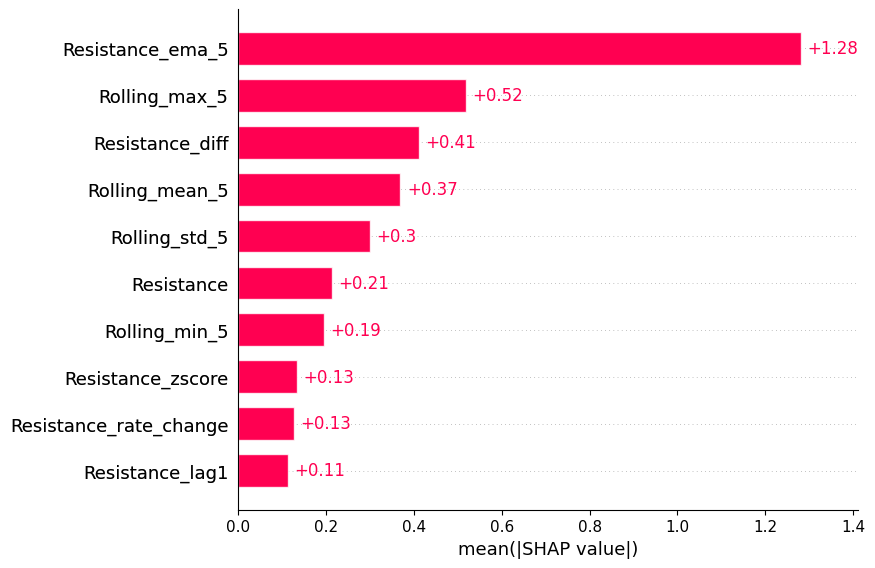

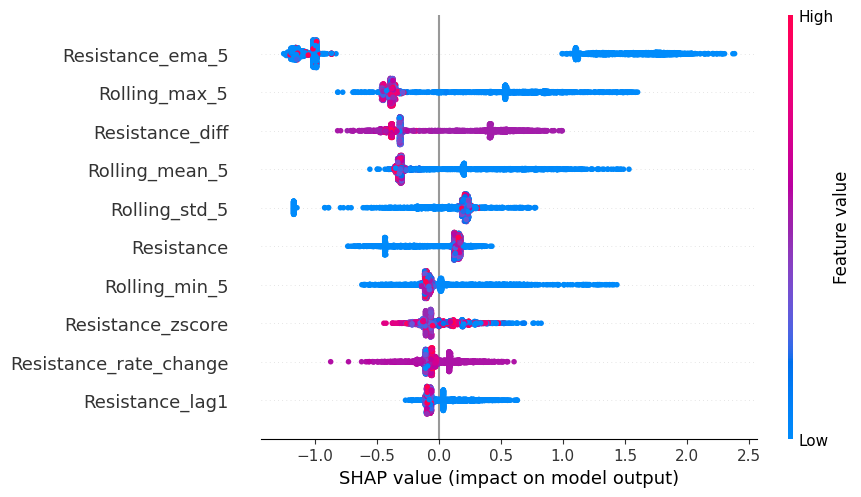


🧠 SHAP Summary for Class: ROUGH
Top features influencing classification:



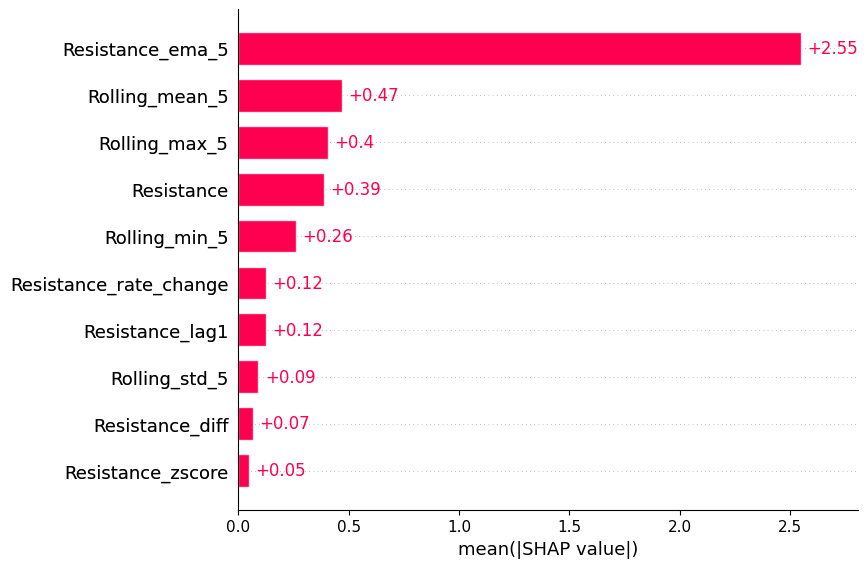

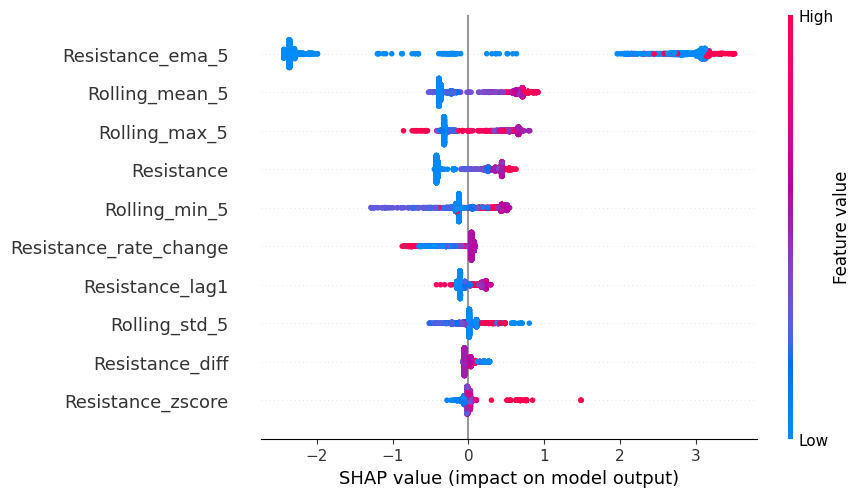


🧠 SHAP Summary for Class: SMOOTH
Top features influencing classification:



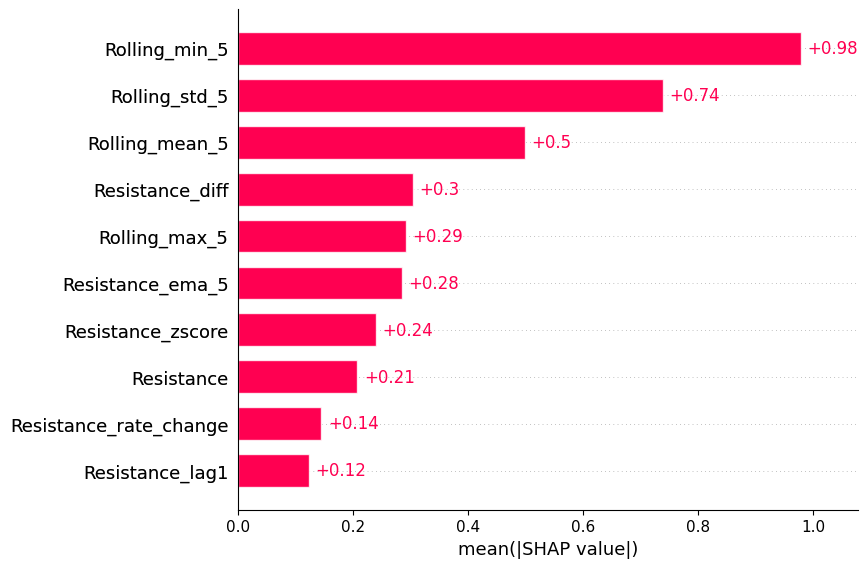

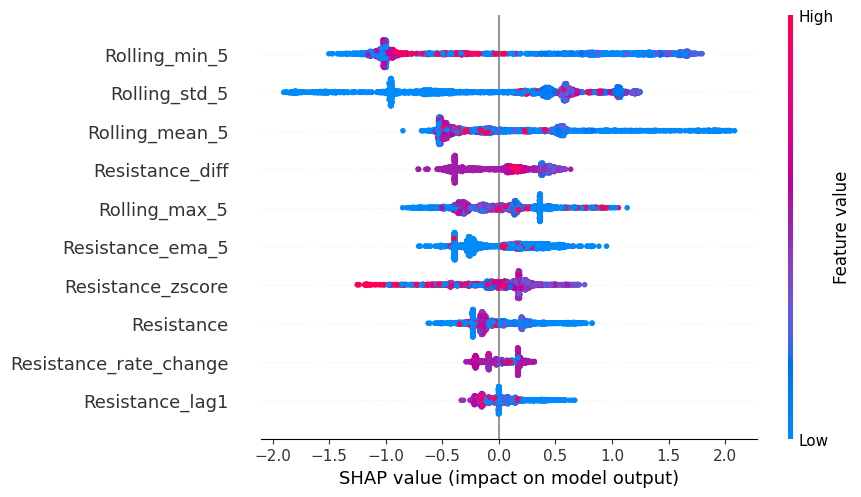


🧠 SHAP Summary for Class: STICKY
Top features influencing classification:



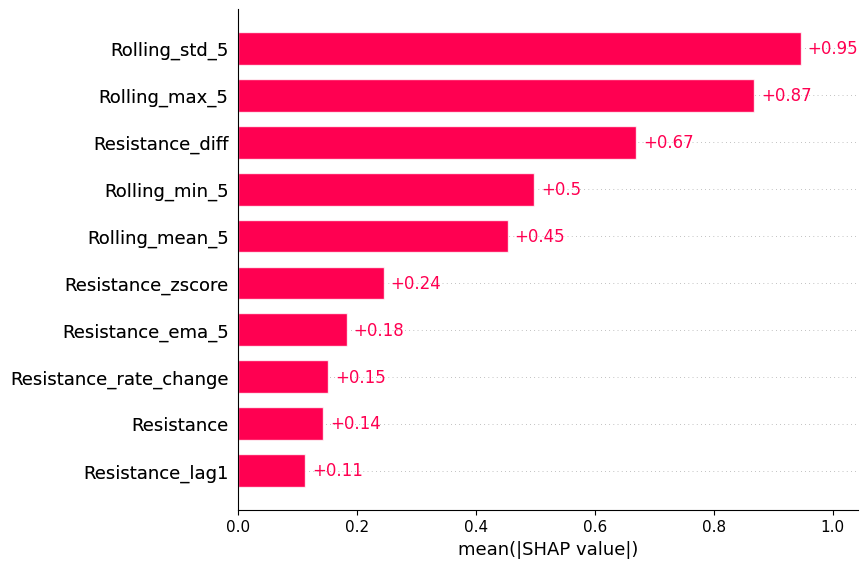

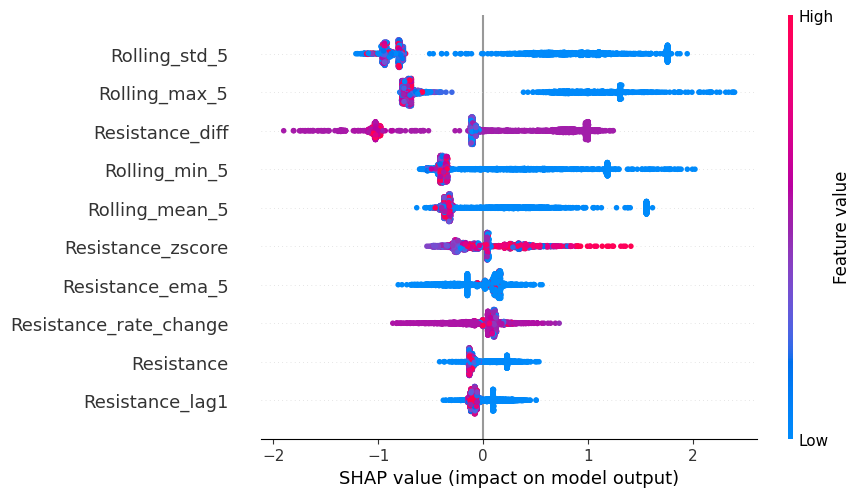

In [6]:
import pandas as pd
import shap
import joblib
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# Load enhanced dataset
df = pd.read_csv(r"E:\SurfacePredictor\data1\Enhanced_Surface_Data.csv")

# Define features and encode target labels
features = [
    'Resistance', 'Resistance_diff', 'Rolling_mean_5', 'Rolling_std_5',
    'Rolling_max_5', 'Rolling_min_5', 'Resistance_rate_change',
    'Resistance_zscore', 'Resistance_lag1', 'Resistance_ema_5'
]

X = df[features]
label_map = {'POLISHED': 0, 'ROUGH': 1, 'SMOOTH': 2, 'STICKY': 3}
y = df['Surface'].map(label_map)

# Retrain or load your best Optuna-tuned model
model = XGBClassifier(
    n_estimators=744,
    max_depth=8,
    learning_rate=0.2325,
    subsample=0.5646,
    colsample_bytree=0.7686,
    gamma=0.6396,
    reg_alpha=0.014,
    reg_lambda=0.7028,
    eval_metric='mlogloss',
    use_label_encoder=False,
    verbosity=0
)
model.fit(X, y)

# Save model
joblib.dump(model, r"E:\SurfacePredictor\models\xgb_optuna_tuned.pkl")

# Initialize SHAP Explainer
explainer = shap.Explainer(model, X)
shap_values = explainer(X)  # shape: (n_samples, n_features, n_classes)

# Define class label mapping
label_map_inv = {0: 'POLISHED', 1: 'ROUGH', 2: 'SMOOTH', 3: 'STICKY'}

# 🔍 SHAP Summary Plots Per Class
for i in range(4):
    print(f"\n🧠 SHAP Summary for Class: {label_map_inv[i]}")
    print("Top features influencing classification:\n")
    
    # Global Bar Plot
    shap.plots.bar(shap_values[..., i])
    
    # Beeswarm Plot (Feature contributions per sample)
    shap.plots.beeswarm(shap_values[..., i], max_display=10)


In [7]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Load data
df = pd.read_csv(r"E:\SurfacePredictor\data1\Enhanced_Surface_Data.csv")

# Encode labels
label_map = {'POLISHED': 0, 'ROUGH': 1, 'SMOOTH': 2, 'STICKY': 3}
df['Encoded_Surface'] = df['Surface'].map(label_map)

# Features
features = [
    'Resistance', 'Resistance_diff', 'Rolling_mean_5', 'Rolling_std_5',
    'Rolling_max_5', 'Rolling_min_5', 'Resistance_rate_change',
    'Resistance_zscore', 'Resistance_lag1', 'Resistance_ema_5'
]
X = df[features].values
y = df['Encoded_Surface'].values

# Setup Stratified k-Fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Apply SMOTE only to training
    X_train_res, y_train_res = SMOTE(random_state=42).fit_resample(X_train, y_train)

    # Train XGBoost
    model = XGBClassifier(
        n_estimators=744,
        max_depth=8,
        learning_rate=0.2325,
        subsample=0.5646,
        colsample_bytree=0.7686,
        gamma=0.6396,
        reg_alpha=0.014,
        reg_lambda=0.7028,
        eval_metric='mlogloss',
        use_label_encoder=False,
        verbosity=0
    )
    model.fit(X_train_res, y_train_res)

    # Predict and score
    y_val_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_val_pred, average='weighted')
    f1_scores.append(f1)

    print(f"\n🔁 Fold {fold} Weighted F1 Score: {f1:.4f}")
    print(classification_report(y_val, y_val_pred, target_names=label_map.keys()))

# Final summary
print("\n✅ Cross-Validation Summary:")
print(f"Average F1 Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"All Fold F1 Scores: {f1_scores}")



🔁 Fold 1 Weighted F1 Score: 0.8781
              precision    recall  f1-score   support

    POLISHED       0.72      0.75      0.74        80
       ROUGH       0.97      1.00      0.98       157
      SMOOTH       0.93      0.89      0.91       104
      STICKY       0.78      0.73      0.75        71

    accuracy                           0.88       412
   macro avg       0.85      0.84      0.85       412
weighted avg       0.88      0.88      0.88       412


🔁 Fold 2 Weighted F1 Score: 0.8883
              precision    recall  f1-score   support

    POLISHED       0.74      0.78      0.76        79
       ROUGH       0.99      0.99      0.99       157
      SMOOTH       0.92      0.92      0.92       104
      STICKY       0.78      0.73      0.75        71

    accuracy                           0.89       411
   macro avg       0.86      0.86      0.86       411
weighted avg       0.89      0.89      0.89       411


🔁 Fold 3 Weighted F1 Score: 0.9008
              precisio

In [9]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 19.2 MB/s eta 0:00:00


In [13]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# Load data
df = pd.read_csv(r"E:\SurfacePredictor\data1\Enhanced_Surface_Data.csv")
features = [
    'Resistance', 'Resistance_diff', 'Rolling_mean_5', 'Rolling_std_5',
    'Rolling_max_5', 'Rolling_min_5', 'Resistance_rate_change',
    'Resistance_zscore', 'Resistance_lag1', 'Resistance_ema_5'
]

label_map = {'POLISHED': 0, 'ROUGH': 1, 'SMOOTH': 2, 'STICKY': 3}
df['Encoded_Surface'] = df['Surface'].map(label_map)

X = df[features]
y = df['Encoded_Surface']

# Split and apply SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.3)
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)

# Base models
xgb_model = XGBClassifier(
    n_estimators=744,
    max_depth=8,
    learning_rate=0.2325,
    subsample=0.5646,
    colsample_bytree=0.7686,
    gamma=0.6396,
    reg_alpha=0.014,
    reg_lambda=0.7028,
    eval_metric='mlogloss',
    use_label_encoder=False,
    verbosity=0
)

lgb_model = LGBMClassifier(random_state=42)
cat_model = CatBoostClassifier(verbose=0, random_state=42)

# Soft Voting Ensemble
voting_model = VotingClassifier(
    estimators=[('xgb', xgb_model), ('lgb', lgb_model), ('cat', cat_model)],
    voting='soft'
)

# Train and Evaluate
voting_model.fit(X_train, y_train)
y_pred = voting_model.predict(X_test)

print("✅ Voting Ensemble Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_map.keys()))

weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"🎯 Weighted F1 Score: {weighted_f1:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2541
[LightGBM] [Info] Number of data points in the train set: 2196, number of used features: 10
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
✅ Voting Ensemble Classification Report:
              precision    recall  f1-score   support

    POLISHED       0.76      0.86      0.80       119
       ROUGH       0.98      0.98      0.98       236
      SMOOTH       0.92      0.92      0.92       156
      STICKY       0.85      0.73      0.78       106

    accuracy                     

In [25]:
import joblib
joblib.dump(voting_model, r"E:\SurfacePredictor\models\voting_ensemble_model.pkl")
print("✅ Voting ensemble model saved successfully.")
import joblib
joblib.dump(voting_model, r"E:\SurfacePredictor\models\voting_ensemble_model.pkl")
print("✅ Voting ensemble model saved successfully.")


✅ Voting ensemble model saved successfully.
✅ Voting ensemble model saved successfully.


In [20]:
import pandas as pd

df = pd.read_csv(r"E:\SurfacePredictor\data1\Enhanced_Surface_Data.csv")
polished_df = df[df['Surface'] == 'POLISHED']
print("🔹 POLISHED - First 5 Rows:")
print(polished_df.head(5))


🔹 POLISHED - First 5 Rows:
   Time  Resistance  Resistance_diff  Rolling_mean_5  Rolling_std_5   Surface  \
0     1      784.50             0.00          787.63      27.131602  POLISHED   
1     2      831.56            47.06          787.63      27.131602  POLISHED   
2     3      782.69           -48.87          787.63      27.131602  POLISHED   
3     4      782.69             0.00          787.63      27.131602  POLISHED   
4     5      756.71           -25.98          787.63      27.131602  POLISHED   

                 FileName  Rolling_max_5  Rolling_min_5  \
0  polished surface 2.xls         831.56         756.71   
1  polished surface 2.xls         831.56         756.71   
2  polished surface 2.xls         831.56         756.71   
3  polished surface 2.xls         831.56         756.71   
4  polished surface 2.xls         831.56         756.71   

   Resistance_rate_change  Resistance_zscore  Resistance_lag1  \
0                0.000000          -0.115364           784.50   
1

In [21]:
rough_df = df[df['Surface'] == 'ROUGH']
print("🔸 ROUGH - First 5 Rows:")
print(rough_df.head(5))


🔸 ROUGH - First 5 Rows:
     Time  Resistance  Resistance_diff  Rolling_mean_5  Rolling_std_5 Surface  \
396     1     5713.76             0.00        4876.514    1184.446773   ROUGH   
397     2     6075.00           361.24        4876.514    1184.446773   ROUGH   
398     3     5342.44          -732.56        4876.514    1184.446773   ROUGH   
399     4     3878.74         -1463.70        4876.514    1184.446773   ROUGH   
400     5     3372.63          -506.11        4876.514    1184.446773   ROUGH   

                  FileName  Rolling_max_5  Rolling_min_5  \
396  rough cement wall.xls        5713.76         661.10   
397  rough cement wall.xls        6075.00         661.10   
398  rough cement wall.xls        6075.00         661.10   
399  rough cement wall.xls        6075.00         760.26   
400  rough cement wall.xls        6075.00        3372.63   

     Resistance_rate_change  Resistance_zscore  Resistance_lag1  \
396                0.000000           0.706867           760.

In [22]:
smooth_df = df[df['Surface'] == 'SMOOTH']
print("🔷 SMOOTH - First 5 Rows:")
print(smooth_df.head(5))


🔷 SMOOTH - First 5 Rows:
      Time  Resistance  Resistance_diff  Rolling_mean_5  Rolling_std_5  \
1181     1     2523.17             0.00        2538.604     331.293128   
1182     2     2350.34          -172.83        2538.604     331.293128   
1183     3     2500.47           150.13        2538.604     331.293128   
1184     4     2227.87          -272.60        2538.604     331.293128   
1185     5     3091.17           863.30        2538.604     331.293128   

     Surface                FileName  Rolling_max_5  Rolling_min_5  \
1181  SMOOTH  smooth cement wall.xls        4665.79        2523.17   
1182  SMOOTH  smooth cement wall.xls        4665.79        2350.34   
1183  SMOOTH  smooth cement wall.xls        3315.20        2350.34   
1184  SMOOTH  smooth cement wall.xls        3039.79        2227.87   
1185  SMOOTH  smooth cement wall.xls        3091.17        2227.87   

      Resistance_rate_change  Resistance_zscore  Resistance_lag1  \
1181                0.000000          -0.

In [23]:
sticky_df = df[df['Surface'] == 'STICKY']
print("🟣 STICKY - First 5 Rows:")
print(sticky_df.head(5))


🟣 STICKY - First 5 Rows:
      Time  Resistance  Resistance_diff  Rolling_mean_5  Rolling_std_5  \
1701     1      782.69             0.00         772.628      10.383009   
1702     2      783.60             0.91         772.628      10.383009   
1703     3      770.08           -13.52         772.628      10.383009   
1704     4      767.40            -2.68         772.628      10.383009   
1705     5      759.37            -8.03         772.628      10.383009   

     Surface              FileName  Rolling_max_5  Rolling_min_5  \
1701  STICKY  sticky surface 2.xls        2313.28         463.13   
1702  STICKY  sticky surface 2.xls        2313.28         463.13   
1703  STICKY  sticky surface 2.xls        2313.28         463.13   
1704  STICKY  sticky surface 2.xls        2313.28         767.40   
1705  STICKY  sticky surface 2.xls         783.60         759.37   

      Resistance_rate_change  Resistance_zscore  Resistance_lag1  \
1701                0.000000           0.969083      

In [26]:
sample = {
    'Resistance': 782.69,
    'Resistance_diff': -48.87,
    'Rolling_mean_5': 787.63,
    'Rolling_std_5': 27.131602,
    'Rolling_max_5': 831.56,
    'Rolling_min_5': 756.71,
    'Resistance_rate_change': -16.289995,
    'Resistance_zscore': -0.182075,
    'Resistance_lag1': 831.56,
    'Resistance_ema_5': 794.354444
}

import pandas as pd
import joblib

# Load the voting ensemble model
model = joblib.load(r"E:\SurfacePredictor\models\voting_ensemble_model.pkl")

# Sample from POLISHED row 2
sample_input = pd.DataFrame([sample])

# Predict
prediction = model.predict(sample_input)[0]

# Label decoding
label_map_inv = {0: 'POLISHED', 1: 'ROUGH', 2: 'SMOOTH', 3: 'STICKY'}
print("🎯 Predicted Surface:", label_map_inv[prediction])


🎯 Predicted Surface: POLISHED


In [27]:
import pandas as pd
import joblib

# Load the model
model = joblib.load(r"E:\SurfacePredictor\models\voting_ensemble_model.pkl")

# Slightly modified ROUGH sample
sample = {
    'Resistance': 3450.00,                  # was 3372.63
    'Resistance_diff': -480.00,             # was -506.11
    'Rolling_mean_5': 4890.00,              # was 4876.514
    'Rolling_std_5': 1200.00,               # was 1184.44
    'Rolling_max_5': 6100.00,               # was 6075.00
    'Rolling_min_5': 3350.00,               # was 3372.63
    'Resistance_rate_change': -98.0,        # was -101.22
    'Resistance_zscore': -1.25,             # was -1.269693
    'Resistance_lag1': 3900.00,             # was 3878.74
    'Resistance_ema_5': 3850.00             # was 3849.58
}

# Predict
df_input = pd.DataFrame([sample])
prediction = model.predict(df_input)[0]

# Decode
label_map_inv = {0: 'POLISHED', 1: 'ROUGH', 2: 'SMOOTH', 3: 'STICKY'}
print("🎯 Predicted Surface:", label_map_inv[prediction])


🎯 Predicted Surface: ROUGH
